In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import os

In [2]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [4]:
outputs_folder = "../data/saved_outputs/val"
folder_models = "same_parameter_real_optimized_function"
sub_folder = "validation_results"
batch_size = 256
nb_epoque = 90
nb_classe = 1000
input_size = 2048


weight_decay_parameter = 1e-4
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 30
decay_rate = 0.1

In [5]:
moyenne_erreur_classe_model = []
loss_epoch = []
weights_epoch = []
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
nb_image_classe = torch.bincount(dataset.labels).to(DEVICE) # compte le nombre de tous les entiers compris entre 0 et l'entier maximum dans le tenseur d'origine

In [6]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
    def forward(self, x): 
        out = self.linear(x) 
        return out
    def load_weights(self, weights) :
        self.load_state_dict(weights)

In [ ]:
correct_predictions=0
model = LogisticRegression(input_size=input_size, num_classes=nb_classe)
model = model.to(DEVICE)
for epoch in range(nb_epoque):

    model.load_weights(torch.load(f'../data/saved_models/{folder_models}/epoch-{epoch}.pt', map_location=DEVICE))    
    erreur_total_classe = torch.zeros(nb_classe, device=DEVICE)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{nb_epoque}]"): 
            
            # Move inputs and labels to the device 
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 
            
            # Forward pass 
            outputs = model(inputs) 
            erreur = torch.nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
            vrai_loss = torch.mean(erreur).item() #recupère la loss du batch  

            _, predicted = torch.max(outputs, 1)

            # Ajout des prédictions correctes au total
            correct_predictions += (predicted == labels).sum().item()
        
            erreur_total_classe.index_add_(0,labels,erreur)

        # process accuracy
        accuracy = 100 * correct_predictions / len(dataset)
        correct_predictions=0
        print(f"Accuracy : {accuracy} %")
        print(f"Global minimized function value : {vrai_loss}") 
        loss_epoch.append(vrai_loss)
        moyenne_erreur_classe_model.append((erreur_total_classe/nb_image_classe).tolist())
        weights_epoch.append(sum(t.abs().sum() for t in model.state_dict().values()))
            

Epoch [1/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 190.94it/s]


Accuracy : 52.444 %
Global minimized function value : 36.010780334472656


Epoch [2/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 291.23it/s]


Accuracy : 59.318 %
Global minimized function value : 27.158344268798828


Epoch [3/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 254.38it/s]


Accuracy : 57.668 %
Global minimized function value : 21.90882110595703


Epoch [4/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 279.00it/s]


Accuracy : 54.896 %
Global minimized function value : 20.321298599243164


Epoch [5/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 280.00it/s]


Accuracy : 54.122 %
Global minimized function value : 20.33029556274414


Epoch [6/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 281.21it/s]


Accuracy : 54.428 %
Global minimized function value : 20.56524085998535


Epoch [7/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 281.18it/s]


Accuracy : 54.952 %
Global minimized function value : 20.555532455444336


Epoch [8/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 235.69it/s]


Accuracy : 54.41 %
Global minimized function value : 20.39168357849121


Epoch [9/90]: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 235.29it/s]


Accuracy : 54.246 %
Global minimized function value : 20.57498550415039


Epoch [10/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 249.94it/s]


Accuracy : 54.188 %
Global minimized function value : 20.58087730407715


Epoch [11/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 237.86it/s]


Accuracy : 54.316 %
Global minimized function value : 20.77569580078125


Epoch [12/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 214.32it/s]


Accuracy : 54.496 %
Global minimized function value : 20.536945343017578


Epoch [13/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 244.39it/s]


Accuracy : 54.566 %
Global minimized function value : 20.493650436401367


Epoch [14/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 213.85it/s]


Accuracy : 54.254 %
Global minimized function value : 20.58327293395996


Epoch [15/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 225.15it/s]


Accuracy : 54.428 %
Global minimized function value : 20.394479751586914


Epoch [16/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 210.75it/s]


Accuracy : 54.254 %
Global minimized function value : 20.585134506225586


Epoch [17/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 239.74it/s]


Accuracy : 54.338 %
Global minimized function value : 20.51688575744629


Epoch [18/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 226.72it/s]


Accuracy : 54.402 %
Global minimized function value : 20.634939193725586


Epoch [19/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 211.43it/s]


Accuracy : 54.588 %
Global minimized function value : 20.551633834838867


Epoch [20/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 232.19it/s]


Accuracy : 54.292 %
Global minimized function value : 20.462432861328125


Epoch [21/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 219.98it/s]


Accuracy : 54.152 %
Global minimized function value : 20.531896591186523


Epoch [22/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 223.87it/s]


Accuracy : 54.45 %
Global minimized function value : 20.557849884033203


Epoch [23/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 223.21it/s]


Accuracy : 54.586 %
Global minimized function value : 20.513111114501953


Epoch [24/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 220.97it/s]


Accuracy : 54.45 %
Global minimized function value : 20.51276206970215


Epoch [25/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 206.64it/s]


Accuracy : 54.248 %
Global minimized function value : 20.46067237854004


Epoch [26/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 197.67it/s]


Accuracy : 54.214 %
Global minimized function value : 20.60856056213379


Epoch [27/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 227.12it/s]


Accuracy : 54.33 %
Global minimized function value : 20.727508544921875


Epoch [28/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 213.85it/s]


Accuracy : 54.522 %
Global minimized function value : 20.56366539001465


Epoch [29/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 203.91it/s]


Accuracy : 54.538 %
Global minimized function value : 20.441617965698242


Epoch [30/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 244.09it/s]


Accuracy : 54.14 %
Global minimized function value : 20.567800521850586


Epoch [31/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 225.53it/s]


Accuracy : 72.754 %
Global minimized function value : 14.10484790802002


Epoch [32/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 242.57it/s]


Accuracy : 75.382 %
Global minimized function value : 14.587653160095215


Epoch [33/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 204.91it/s]


Accuracy : 76.47 %
Global minimized function value : 13.952616691589355


Epoch [34/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 195.70it/s]


Accuracy : 77.066 %
Global minimized function value : 12.957083702087402


Epoch [35/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 226.59it/s]


Accuracy : 77.492 %
Global minimized function value : 11.898510932922363


Epoch [36/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 222.34it/s]


Accuracy : 77.678 %
Global minimized function value : 10.839289665222168


Epoch [37/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 220.47it/s]


Accuracy : 77.908 %
Global minimized function value : 9.80947208404541


Epoch [38/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 187.64it/s]


Accuracy : 78.046 %
Global minimized function value : 8.846040725708008


Epoch [39/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 243.93it/s]


Accuracy : 78.198 %
Global minimized function value : 7.973069667816162


Epoch [40/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 248.41it/s]


Accuracy : 78.158 %
Global minimized function value : 7.178330898284912


Epoch [41/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 199.28it/s]


Accuracy : 78.348 %
Global minimized function value : 6.471495151519775


Epoch [42/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 198.35it/s]


Accuracy : 78.312 %
Global minimized function value : 5.872254848480225


Epoch [43/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 214.21it/s]


Accuracy : 78.34 %
Global minimized function value : 5.380127906799316


Epoch [44/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 199.49it/s]


Accuracy : 78.268 %
Global minimized function value : 4.989279270172119


Epoch [45/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 218.63it/s]


Accuracy : 78.298 %
Global minimized function value : 4.671684265136719


Epoch [46/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 191.97it/s]


Accuracy : 78.17 %
Global minimized function value : 4.40420389175415


Epoch [47/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 172.21it/s]


Accuracy : 78.138 %
Global minimized function value : 4.174629211425781


Epoch [48/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 193.01it/s]


Accuracy : 77.894 %
Global minimized function value : 3.9777305126190186


Epoch [49/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 208.51it/s]


Accuracy : 77.822 %
Global minimized function value : 3.8093154430389404


Epoch [50/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 192.66it/s]


Accuracy : 77.604 %
Global minimized function value : 3.666182041168213


Epoch [51/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 162.23it/s]


Accuracy : 77.412 %
Global minimized function value : 3.544938325881958


Epoch [52/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 192.85it/s]


Accuracy : 77.12 %
Global minimized function value : 3.4427807331085205


Epoch [53/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 183.22it/s]


Accuracy : 76.928 %
Global minimized function value : 3.3569176197052


Epoch [54/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 206.10it/s]


Accuracy : 76.574 %
Global minimized function value : 3.2851123809814453


Epoch [55/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 170.66it/s]


Accuracy : 76.362 %
Global minimized function value : 3.224687337875366


Epoch [56/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 190.65it/s]


Accuracy : 76.026 %
Global minimized function value : 3.1729092597961426


Epoch [57/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 205.88it/s]


Accuracy : 75.868 %
Global minimized function value : 3.1278512477874756


Epoch [58/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 182.89it/s]


Accuracy : 75.572 %
Global minimized function value : 3.0884463787078857


Epoch [59/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 199.49it/s]


Accuracy : 75.47 %
Global minimized function value : 3.054417133331299


Epoch [60/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 180.56it/s]


Accuracy : 75.274 %
Global minimized function value : 3.0256927013397217


Epoch [61/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 181.15it/s]


Accuracy : 77.908 %
Global minimized function value : 2.607290744781494


Epoch [62/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 208.17it/s]


Accuracy : 78.894 %
Global minimized function value : 2.5815722942352295


Epoch [63/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 178.09it/s]


Accuracy : 79.296 %
Global minimized function value : 2.5909335613250732


Epoch [64/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 171.93it/s]


Accuracy : 79.586 %
Global minimized function value : 2.6052753925323486


Epoch [65/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 175.83it/s]


Accuracy : 79.696 %
Global minimized function value : 2.615417242050171


Epoch [66/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 169.60it/s]


Accuracy : 79.764 %
Global minimized function value : 2.6192688941955566


Epoch [67/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 193.63it/s]


Accuracy : 79.816 %
Global minimized function value : 2.616966962814331


Epoch [68/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 172.76it/s]


Accuracy : 79.848 %
Global minimized function value : 2.6094558238983154


Epoch [69/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 206.97it/s]


Accuracy : 79.86 %
Global minimized function value : 2.5978379249572754


Epoch [70/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 200.51it/s]


Accuracy : 79.884 %
Global minimized function value : 2.583040952682495


Epoch [71/90]: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 190.01it/s]


Accuracy : 79.894 %
Global minimized function value : 2.5660898685455322


Epoch [72/90]:  92%|███████████████████████████████████████████████████████████     | 181/196 [00:00<00:00, 213.47it/s]

In [8]:
result_folder = f"../data/saved_result/{sub_folder}"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
    
torch.save(loss_epoch, f'{result_folder}/loss.pt')
torch.save(moyenne_erreur_classe_model, f'{result_folder}/moyenne_erreur_classe_model.pt')
torch.save(weights_epoch, f'{result_folder}/weights_epoch.pt')


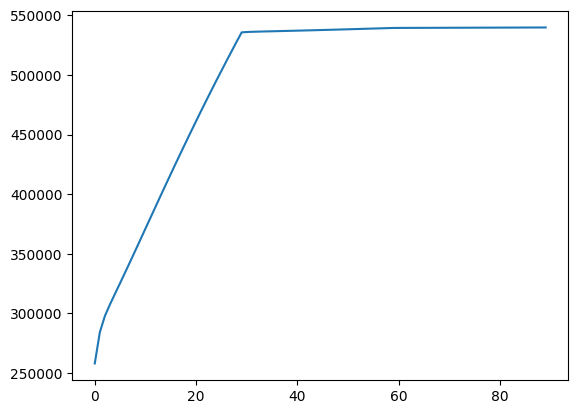

In [9]:
plt.plot(torch.tensor(weights_epoch).to('cpu'))


In [10]:
moyenne_erreur_classe_model = torch.tensor(moyenne_erreur_classe_model)
t_k = [torch.argmin(moyenne_erreur_classe_model[:,l]).item() for l in range(nb_classe)]
r_k = [torch.min(moyenne_erreur_classe_model[:,m]).item() for m in range(nb_classe)]
t = torch.argmin(torch.tensor(loss_epoch))
r_t = torch.min(torch.tensor(loss_epoch))
decalage = torch.abs(torch.tensor(t_k) - t)
regret = torch.abs(torch.tensor(r_k) - r_k[t])

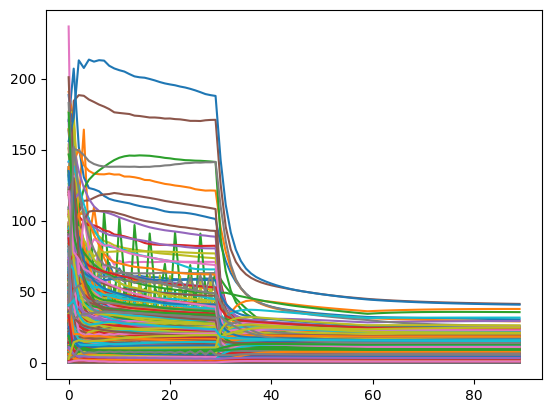

In [11]:
plt.plot(loss_epoch,color='black')
for n in range(0,1000):
    plt.plot(moyenne_erreur_classe_model[:,n])

In [12]:
torch.bincount(torch.tensor(t_k))

tensor([ 82,  25,  24,  13,   6,   8,   4,   1,   3,   1,   1,   1,   0,   2,
          2,   3,   5,   0,   3,   1,   1,   0,   3,   2,   1,   1,   3,   6,
         18,  61,  51,  26,  12,   5,   8,   6,   3,   3,   5,   2,   4,   1,
          3,   1,   2,   1,   1,   2,   2,   2,   1,   1,   0,   1,   1,   0,
          0,   0,   0,  61,   0,   0,   1,   1,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,   1,   1,   0, 507])

In [13]:
for tens in (torch.tensor(t_k)==59).nonzero()[93:94,0]:
    plt.plot(moyenne_erreur_classe_model[:,tens])

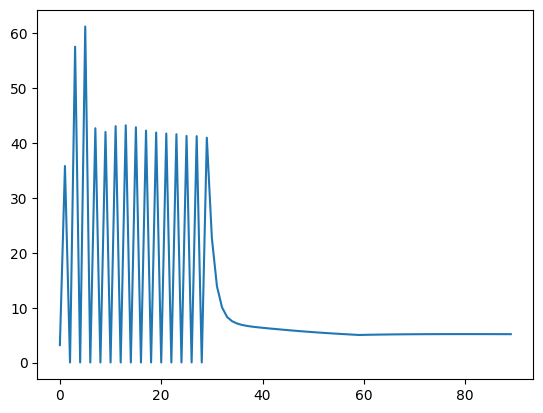

In [14]:
plt.plot(moyenne_erreur_classe_model[:,349])